# Отток клиентов банка

Проектная работа по итогам спринта «Обучение с учителем» / Яндекс.Практикум

## Основные выводы

Максимальное значение _F1_-меры, равное 0,616, дала модель **случайного леса** с 835 деревьями и максимальной глубиной дерева 9.

Балансирование классов целевого признака путём **взвешивания** позволило увеличить _F1_ не меньше чем на 0,02. Только при использовании взвешенной модели удалось достичь значений _F1_ больше 0,59.

**Стандартизация** (scaling) числовых признаков не привела к росту _F1_, хотя позволила уменьшить количество деревьев.

При совместном применении стандартизации и взвешивания эффекты обоих методов объединились.

Категориальные признаки, значения которых представлены не числовыми величинами, были преобразованы **прямым кодированием** (OHE).

Для подбора моделей использовался **перебор разреженных диапазонов** количества деревьев и максимальной глубины дерева, а затем окрестности локальных максимумов _F1_ изучались перебором более узких и более плотных диапазонов.

Предоставленный набор данных неадекватен и неправдоподобен с точки зрения предметной области (банковского дела), поэтому пришлось отвлечься от семантики признаков и рассматривать задачу как чисто техническое упражнение на оптимизацию метрик модели.

## Уточнение задачи

Задача проекта сформулирована так:

> Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
> 
> Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
> 
> Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0,59. Проверьте *F1*-меру на тестовой выборке самостоятельно.
> 
> Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.
> 
> Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

В качестве источника данных предоставлена таблица со сведениями о вымышленной совокупности клиентов банка: возраст, пол, кредитный рейтинг и пр. Один из столбцов таблицы содержит информацию о том, перестал ли клиент пользоваться услугами банка. Задача сводится к тому, чтобы построить модель машинного обучения, которая предсказывает значение этого столбца на основании остальных столбцов.

## Подготовка данных

Получим данные из источника, изучим их пригодность для решения поставленной задачи, преобразуем данные так, как будет лучше для этого решения.

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, matthews_corrcoef

import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO

In [2]:
random_state_default = 19180511

# We have a habit in writing articles published in scientific journals to make the work
# as finished as possible, to cover all the tracks, to not worry about the blind alleys
# or to describe how you had the wrong idea first, and so on. So there isn't any place
# to publish, in a dignified manner, what you actually did in order to get to do the work.
# – Richard Feynman about Jupyter Hub :-)

In [3]:
df = pd.read_csv('/datasets/Churn.csv')

### Столбцы набора данных

В наборе данных 14 столбцов, перечисленных ниже вместе с расшифровкой каждого столбца в соответствии с описанием задачи. Столбец `Exited` обозначает факт ухода клиента и будет использоваться как целевой признак при построении моделей.

В наборе данных 10 000 строк. Пропущенные значения есть только в столбце `Tenure` (клиентский стаж).

In [4]:
meanings = {'Age': 'Возраст', 'Balance': 'Баланс на счёте', 'CreditScore': 'Кредитный рейтинг',
            'CustomerId': 'Уникальный идентификатор клиента', 'EstimatedSalary': 'Предполагаемая зарплата',
            'Exited': 'Факт ухода клиента', 'Gender': 'Пол', 'Geography': 'Страна проживания',
            'HasCrCard': 'Наличие кредитной карты', 'IsActiveMember': 'Активность клиента',
            'NumOfProducts': 'Количество продуктов банка, используемых клиентом',
            'RowNumber': 'Индекс строки в данных', 'Surname': 'Фамилия',
            'Tenure': 'Сколько лет человек является клиентом банка'}

buffer = StringIO()
df.info(buf=buffer)
info = [line.split() for line in buffer.getvalue().splitlines()[3:-2]]
info_df = pd.DataFrame(info[2:], columns=info[0]).drop(columns=['#', 'Count'])
info_df['Meaning'] = info_df['Column'].apply(lambda s: meanings[s])
info_df.sort_values('Column').reset_index(drop=True)

,Column,Non-Null,Dtype,Meaning
0,Age,10000,int64,Возраст
1,Balance,10000,float64,Баланс на счёте
2,CreditScore,10000,int64,Кредитный рейтинг
3,CustomerId,10000,int64,Уникальный идентификатор клиента
4,EstimatedSalary,10000,float64,Предполагаемая зарплата
5,Exited,10000,int64,Факт ухода клиента
6,Gender,10000,object,Пол
7,Geography,10000,object,Страна проживания
8,HasCrCard,10000,int64,Наличие кредитной карты
9,IsActiveMember,10000,int64,Активность клиента


#### Проблемы столбцов

Набор столбцов в целом выглядит неправдоподобно с точки зрения банковской практики. Изучив ссылку на источник ([kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)), можно заключить, что мы имеем дело с полностью искусственным набором данных, которые не соответствуют никакому реальному банку и никаким реальным клиентам.

Это позволяет отвлечься от бизнес-логики (которую следовало бы учитывать в реальной задаче) и рассматривать проект как чисто техническое упражнение на оптимизацию метрик модели.

Также в этом проекте мы не будем проверять, что предоставленные данные репрезентативны относительно изучаемой совокупности (предположительно, всех клиентов банка). В реальной задаче это был бы обязательный этап.

Хотя «верблюжий» стиль записи названий столбцов не соответствует общепринятой практике Python, в данном случае не вижу смысла их переименовывать. В конце концов, в коде эти названия почти всюду используются как строковые значения, а не как идентификаторы.

Также отмечу, что набор столбцов вызвал у меня «индусские» ассоциации ещё до того, как я изучил источник и узнал, что составитель набора данных — Tarun Sunkaraneni, который на момент размещения датасета на Kaggle был студентом Университета Юты.

### Целевой признак: столбец `Exited` (факт ухода клиента)

Столбец `Exited` — бинарный: в нём только значения `0` и `1`:

In [5]:
print('Уникальные значения столбца Exited:', set(df.Exited.unique()))

Уникальные значения столбца Exited: {0, 1}


Хотя это не указано в описании задачи, было бы логично предположить, что `1` означает, что клиент ушёл, а `0` — что он не ушёл. Впрочем, я уверен в этом не на сто процентов, учитывая происхождение составителя набора данных. С другой стороны, для решения задачи не требуется семантика значений: модель должна удовлетворительно предсказывать значения `0` и `1` независимо от того, какой смысл они несут.

Поскольку столбец — бинарный, перед нами задача _бинарной классификации_. Будем использовать модель случайного леса (классификатор `RandomForestClassifier`), потому что на учебных примерах она зарекомендовала себя лучше других изученных классификаторов.

#### Временны́е проблемы в данных

В реальной задаче я бы сомневался в пригодности данных, пока не удастся уточнить временнýю информацию. К какому периоду времени относятся сведения об уходах клиентов? Насколько свежие эти сведения? Достаточно ли они однородны по времени? (Не выяснится ли, что половина данных собрана в течение десяти лет, а другая половина — на прошлой неделе?)

В описании задачи предлагается «спрогнозировать, уйдёт клиент в ближайшее время или нет», однако тоже не уточняется, какое «ближайшее время» имеется в виду — скажем, ближайшая неделя или ближайшие несколько лет.

Проблемы временнóй неопределённости касаются не только `Exited`, но и других столбцов: большинство из них описывают признаки, которые могут меняться с течением времени (или даже обязательно меняются — как, например, возраст клиента). Отсутствие временнóй информации — главный фактор неправдоподобия всего набора данных.

#### Баланс классов `Exited`

Столбец `Exited` весьма несбалансирован: около 80 % его ячеек имеют значение `0` и только 20 % (то есть в 4 раза меньше) — значение `1`:

In [6]:
def classes_dist(column):
    """
    Информация о распределении классов бинарного признака column:
    
    – набор данных (DataFrame) с абсолютным количеством и процентной долей
      значений каждого класса,
    - отношение количества значений большего класса к меньшему
    
    """
    c1 = column.value_counts()
    c2 = (column.value_counts(normalize=True) * 100).round(1)
    return pd.DataFrame({'n': c1, '%': c2}), max(c1) / min(c1)

In [7]:
table, ratio = classes_dist(df.Exited)
print('Распределение классов 0 и 1 для признака Exited:')
display(table)
print(f'Соотношение объёмов классов: {ratio:.2f}')

Распределение классов 0 и 1 для признака Exited:


,n,%
0,7963,79.6
1,2037,20.4


Соотношение объёмов классов: 3.91


### Вспомогательные инструменты

Объявим функцию `plots`, которая автоматизирует построение диаграмм для числовых признаков: она размещает в одной и той же области диаграмму размаха и гистограмму на общей оси _X_.

In [8]:
def plots(column, xticks=None, bins='auto', labels=False):
    """
    Диаграмма размаха и гистограмма для признака colunm
    в общей области
    
    Параметры:
    – xticks — метки для оси X
    – bins — «корзины» разбиения на частотные классы
    
    """
    data = df[column]
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
        gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(data=data, ax=ax_box, orient='h')
    sns.histplot(data=data, ax=ax_hist, bins=bins)
    ax_box.set(xlabel='')
    if(xticks is not None):
        plt.xticks(xticks)
    if(labels):
        for i, p in enumerate(ax_hist.patches):
            if i%2 != 0:
                continue
            ax_hist.annotate(
                text=f"{p.get_height():1.0f}", xy=(p.get_x() + p.get_width() / 2., p.get_height() - 10), 
                xycoords='data', ha='center', va='center', fontsize=12, color='black', xytext=(0,6), 
                textcoords='offset points', clip_on=True)
    plt.show()

#### Замечание об ограничениях Jupyter Hub

Согласитесь, что было бы нагляднее сначала показать готовую диаграмму, а потом представить функцию, которая её выводит. Более того, функция `plots` имеет чисто вспомогательный характер, а её код не содержит ничего ценного с точки зрения поставленной задачи (построить модель машинного обучения). Так что по логике изложения объявление функции следовало бы поместить в «приложение» в конце тетрадки. Однако Jupyter не позволяет этого сделать: ячейки кода должны идти в том же порядке, в котором они выполняются, а функцию нельзя вызвать до того, как она объявлена.

Это только одно из проявлений фундаментального ограничения Jupyter’а. Оптимальный порядок, в котором стóит излагать результаты анализа другим людям, в общем случае не обязан совпадать с оптимальным порядком, в котором пишется программный код для этого анализа. Но Jupyter не даёт отделить одно от другого, из-за чего изложение очевидным образом страдает.

Было бы удобнее, если бы Jupyter или другой подобный инструмент позволял связывать с одним и тем же кодом разные представления для разных нужд. Например, менеджеру будет полезен чисто текстовый отчёт с избранными диаграммами и таблицами. Старший DS, возможно, захочет изучить технические внутренности самóй построенной модели. Даже программистам будет удобнее воспринимать код, если сначала дать верхнеуровневое представление о его архитектуре и ключевых узлах. Естественно, такая гипотетическая система должна по-прежнему позволять читателям перейти к сырому исходному коду и изучить все подробности.

Я интересовался, не существует ли готовых решений такого рода (например, в виде расширений для Jupyter), но ничего не нашёл.

### `Tenure` — клиентский стаж

Столбец `Tenure`, описанный в условии задачи как «сколько лет человек является клиентом банка», содержит только целые числа от 0 до 10 включительно. По-видимому, это стоит трактовать как количество _полных_ лет клиентского стажа. Гистограмма показывает практически равномерное распределение (на каждое значение `Tenure` приходится около 900 клиентов), за исключением крайних значений 0 и 10, на которые приходится вполовину меньше: 382 и 446 клиентов соответственно.

Такое распределение выглядит ненормально со статистической точки зрения и противоестественно с точки зрения предметной области.

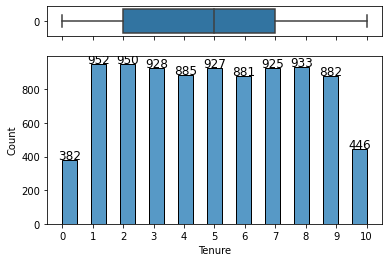

In [9]:
plots('Tenure', xticks=list(range(0, 11)), labels=True)

In [10]:
# Я не разобрался, как приписать значения прямо над столбцами на гистограмме,
# поэтому вычисляю значения отдельно

tn = df.Tenure
tn.value_counts().sort_index()

0.0     382
1.0     952
2.0     950
3.0     928
4.0     885
5.0     927
6.0     881
7.0     925
8.0     933
9.0     882
10.0    446
Name: Tenure, dtype: int64

#### Пропущенные значения

`Tenure` — единственный столбец с пропущенными значениями: их 909 штук, или 9,1 % от всего набора данных:

In [11]:
na_tenure = df.Tenure.isna().sum()
print('Пропущенных значений в столбце Tenure:', na_tenure)
print(f'Доля от всего набора данных: {(na_tenure / len(df.Tenure)):.1%}')

Пропущенных значений в столбце Tenure: 909
Доля от всего набора данных: 9.1%


В этой задаче считаю целесообразным просто удалить все строки с пропущенными значениями. Оказывается, после этого соотношение объёмов классов `Exited` останется ровно таким же, как было изначально (80 / 20 %), что в очередной раз выдаёт искусственность данных.

In [12]:
df1 = df.dropna()
table, ratio = classes_dist(df1.Exited)
print('Распределение классов 0 и 1 для признака Exited после удаления пропусков:')
display(table)
print(f'Соотношение объёмов классов: {ratio:.2f}')

Распределение классов 0 и 1 для признака Exited после удаления пропусков:


,n,%
0,7237,79.6
1,1854,20.4


Соотношение объёмов классов: 3.90


### Числовые столбцы

#### `Age` — возраст клиента

Возраст клиентов банка представлен целыми числами в диапазоне от 18 до 92 лет включительно.

In [13]:
print('Диапазон Age: от', df.Age.min(), 'до', df.Age.max(), 'лет')

Диапазон Age: от 18 до 92 лет


Самыми пожилыми клиентами банка оказались двое мужчин из Франции с чисто французскими и типично мужскими фамилиями `Rogova` и `T'ien`, причём второй стал клиентом банка всего год назад. Интересно, что в столь почтенном возрасте оба клиента всё ещё получают зарплату (судя по значениям столбца `EstimatedSalary`). Вот уж, действительно, বন্দে মাতরম্‌.

In [14]:
df[df.Age == df.Age.max()][['Surname', 'Geography', 'Gender', 'Age', 'Tenure', 'EstimatedSalary']]

,Surname,Geography,Gender,Age,Tenure,EstimatedSalary
6443,Rogova,France,Male,92,NaN,195563.99
6759,T'ien,France,Male,92,1.0,34436.83


Распределение значений столбца `Age` примерно колоколообразное, ощутимо скошенное вправо. Это правдоподобно с точки зрения предметной области, хотя в реальной банковской статистике стоило бы ожидать более заметного спада в районе пенсионного возраста: здесь массово прекращаются зарплатные счета, корпоративные социальные программы и другие продукты для работающих клиентов.

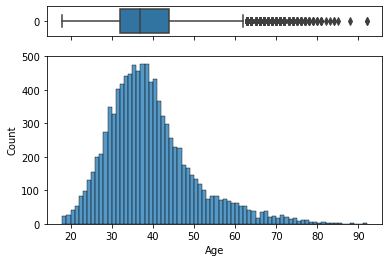

In [15]:
plots('Age', bins=range(18, 93))

Думаю, что в реальной задаче я бы привёл все значения возраста к диапазонам: например, «18–29 лет», «30–45 лет» и т. д.

#### `Balance` — баланс на счёте

`Balance` — самый загадочный столбец набора данных. Он описан как «баланс на счёте» — при том, что в реальной банковской практике это _очень_ переменная величина, не говоря уже о том, что у одного и того же клиента может быть больше одного счёта; к какому же из них будет относиться значение `Balance`?

В реальной практике подобный столбец мог бы означать, например, _средний_ (или медианный) баланс по всем счетам одного типа (например, депозитным) за некоторый промежуток времени.

In [16]:
print('Диапазон Balance: от', df.Balance.min(), 'до', df.Balance.max(),
     ', медиана:', df.Balance.median())

Диапазон Balance: от 0.0 до 250898.09 , медиана: 97198.54000000001


Несмотря на то, что данные имитируют банковскую статистику, в их описании не хватает важнейшей информации: в какой валюте выражены денежные суммы (в том числе `Balance`)? Можно разве что предположить, что речь идёт о **евро**: в статистике фигурируют страны Еврозоны, и различные источники в Интернете оценивают средний капитал западноевропейцев примерно в 85–100 тыс. евро.

Распределение баланса (за исключением значения `0`) — почти идеально нормальное, что категорически не похоже на настоящую банковскую статистику. В реальной жизни благосостояние согласуется с распределением Парето: острый пик в начале распределения (обычно в районе средней продуктовой корзины) и очень длинный хвост вплоть до единичных клиентов, ворочающих десятками миллионов. (Счета на сотни миллионов евро / долларов и больше — отдельная тема.)

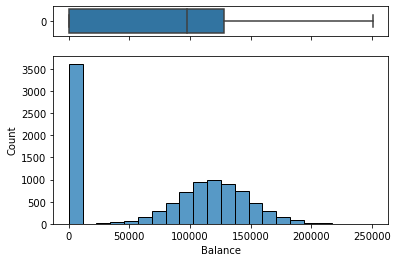

In [17]:
plots('Balance')

Наоборот, большáя доля нулевых значений (3617 шт., или 36,2 % от всего набора данных) похожа на реальную статистику. Существует множество причин, почему баланс клиента может быть равен нулю, например:

- Человек получил промо-карту банка в ходе рекламной акции и никогда ею не пользовался.
- Человек вывел все свои средства и перестал пользоваться услугами банка, однако не расторгал договор.
- Человек — должник, который продолжает числиться клиентом банка, пока его долг не урегулирован.

В совокупности эти и другие причины и дают такую большую долю нулевых значений.

In [18]:
bal = df.Balance
print('Нулевых значений в столбце Balance:', bal[bal == 0].count())
print(f'Доля от всего набора данных: {(bal[bal == 0].count() / len(bal)):.1%}')

Нулевых значений в столбце Balance: 3617
Доля от всего набора данных: 36.2%


#### `CreditScore` — кредитный рейтинг

Значения кредитного рейтинга охватывают диапазон от 350 до 850 неизвестных единиц, хотя в реальной практике значения такой семантики либо начинаются от 0, либо расположены вокруг 0 (положительные значения дают бонус при решении о предоставлении кредита, отрицательные — пенальти).

In [19]:
print('Диапазон CreditScore: от', df.CreditScore.min(), 'до', df.CreditScore.max())

Диапазон CreditScore: от 350 до 850


Распределение `CreditScore` — колоколообразное, немного скошенное вправо, за исключением выброса на максимальном значении `850`.

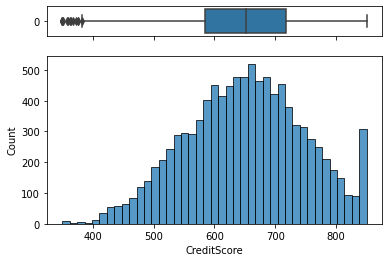

In [20]:
plots('CreditScore')

Выброс на максимальном значении в реальной практике мог бы объясняться тем, что в данной системе кредитный рейтинг не может превышать 850, сколько бы «достижений» ни накапливал клиент. Поэтому, начиная с некоторого уровня «достижений», всем клиентам присваивается один и тот же максимальный рейтинг.

In [21]:
cs = df.CreditScore
csm = cs[cs == cs.max()].count()
print(f'Максимальных значений ({cs.max()}) в столбце CreditScore: {csm}')
print(f'Доля от всего набора данных: {(csm / len(cs)):.1%}')

Максимальных значений (850) в столбце CreditScore: 233
Доля от всего набора данных: 2.3%


#### `EstimatedSalary` — предполагаемая зарплата

Для столбца `EstimatedSalary`, как и для `Balance`, в описании набора данных не указана валюта, а также период времени, за который исчисляется зарплата. Можно условно предположить, что имеется в виду **евро в год** — по крайней мере, при такой интерпретации порядок значений выглядит правдоподобно.

Сами значения практически равномерно распределены между 0 и 200 000, при том что для реальных зарплат совершенно неправдоподобно ни равномерное распределение, ни ограничение сверху круглой величиной 200 000 (независимо от валюты).

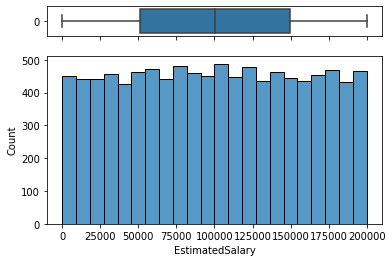

In [22]:
plots('EstimatedSalary')

### Категориальные и порядковые столбцы

#### `Gender` — пол

Мужчины составляют немного больше половины всей выборки, женщины — немного меньше половины.

In [23]:
table, ratio = classes_dist(df.Gender)
print('Распределение классов для признака Gender:')
display(table)

Распределение классов для признака Gender:


,n,%
Male,5457,54.6
Female,4543,45.4


#### `Geography` — страна проживания

Половина клиентов — из Франции, остальные почти поровну распределены между Германией и Испанией. С точки зрения смысла и английского языка правильнее было бы назвать столбец `Country`.

In [24]:
table, ratio = classes_dist(df.Geography)
print('Распределение классов для признака Geography:')
display(table)

Распределение классов для признака Geography:


,n,%
France,5014,50.1
Germany,2509,25.1
Spain,2477,24.8


#### `HasCrCard` — наличие кредитной карты

Кредитная карта есть у 71 % клиентов из выборки.

In [25]:
table, ratio = classes_dist(df.HasCrCard)
print('Распределение классов для признака HasCrCard:')
display(table)

Распределение классов для признака HasCrCard:


,n,%
1,7055,70.6
0,2945,29.4


#### `IsActiveMember` — активность клиента

Из описания задачи неизвестно, что конкретно означает «активность клиента», однако этот признак положителен чуть больше чем у половины клиентов и отрицателен у остальных.

In [26]:
table, ratio = classes_dist(df.IsActiveMember)
print('Распределение классов для признака IsActiveMember:')
display(table)

Распределение классов для признака IsActiveMember:


,n,%
1,5151,51.5
0,4849,48.5


#### `NumOfProducts` — количество продуктов банка, используемых клиентом

Половина клиентов использует 1 продукт банка, почти половина — 2 продукта, оставшаяся небольшая доля — 3 или 4 продукта. Впрочем, смысл признака `NumOfProducts` опять остаётся непонятным.

In [27]:
table, ratio = classes_dist(df.NumOfProducts)
print('Распределение классов для признака NumOfProducts:')
display(table)

Распределение классов для признака NumOfProducts:


,n,%
1,5084,50.8
2,4590,45.9
3,266,2.7
4,60,0.6


### Преобразование набора данных

Удалим из набора данных строки с пропущеннными ячейками.

In [28]:
df.dropna(inplace=True)

Удалим столбцы `CustomerId`, `RowNumber` и `Surname`, которые не нужны для модели.

In [29]:
df.drop(['CustomerId', 'RowNumber', 'Surname'], axis=1, inplace=True)

Категориальные столбцы, значения в которых представлены не числовыми величинами (`Gender` и `Geography`), преобразуем к бинарным столбцам прямым кодированием (OHE).

In [30]:
# числовые столбцы
num_cols = ['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'NumOfProducts', 'Tenure']

# категориальные столбцы
cat_cols = ['Gender', 'Geography']

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

#### Замечание об оптимизации факторов

В реальной задаче я бы ещё изучил взаимосвязь прогнозирующих признаков, чтобы удалить лишние признаки: те, которые слишком сильно ассоциированы с другими и / или слишком мало влияют на целевой признак.

## Построение модели машинного обучения

### Обучающая, валидационная и тестовая выборки

При работе с моделями будем использовать выборки трёх типов: _обучающую_, _валидационную_ и _тестовую_. В коде будем обозначать выборки по схеме `ось_тип_источник`, где:

- _Ось:_ `x` — прогнозирующие признаки, `y` — целевой признак
- _Тип_ выборки: `train` — обучающая, `valid` — валидационная, `test` — тестовая
- _Источник_ (только для целевого признака): `true` — истинные значения, `pred` — значения, предсказанные моделью

Например:

- `x_train` — прогнозирующие признаки обучающей выборки,
- `y_test_pred` — целевой признак, предсказанный моделью на тестовой выборке.

Функция `get_samples()` разделяет исходный набор данных на три выборки перечисленных типов и отделяет прогнозирующие признаки от целевого.

In [31]:
def get_samples(df):
    """
    Разделяет набор данных df на обучающую, валидационную и тестовую выборки в пропорции 60/20/20 %.
    Выборки стратифицированы по целевому признаку Exited.
    
    Возвращает словарь с 6 значениями:
    {'x_train', 'x_valid', 'x_test' — прогнозирующие признаки обучающей, валидационной и тестовой выборки,
     'y_train_true', 'y_valid_true', 'y_test_true' — целевой признак соответствующих выборок}
    """
    result = {}
    x, y = df.drop(['Exited'] , axis=1), df['Exited']
    result['x_train'], x_rest, result['y_train_true'], y_rest = train_test_split(
        x, y, test_size=0.4, random_state=random_state_default, stratify=y
    )
    result['x_valid'], result['x_test'], result['y_valid_true'], result['y_test_true'] = train_test_split(
        x_rest, y_rest, test_size=0.5, random_state=random_state_default, stratify=y_rest
    )
    return result

### Подбор модели

В описании задачи предлагается подобрать модель бинарной классификации со значением _F1_-меры не менее 0,59. Будем рассматривать модели случайного леса (`RandomForestClassifier`), варьируя параметры:

- количество деревьев (`n_estimators`),
- максимальная глубина дерева (`max_depth`).

#### Алгоритм подбора модели

Код, который я использовал для подбора модели, полностью **не умещается** в учебную тетрадку Jupyter: на некоторых его фрагментах тетрадка зависает, а некоторые другие выполняются в ней намного дольше, чем на моём локальном компьютере. В этом разделе я описываю общий подход к подбору модели и демонстрирую избранные фрагменты кода, которые здесь успешно выполняются за разумное время.

Самым простым решением было бы перебрать во вложенном цикле все возможные комбинации гиперпараметров:

```python
for depth in range(1, много):  # максимальная глубина дерева
    for est in range(1, много):  # количество деревьев
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, …)
        # обучаем модель, вычисляем F1, находим максимум по всем моделям
```

Однако с таким полным перебором не справляется даже мой локальный компьютер. По опыту я считаю разумным проверять глубину дерева в диапазоне до 50 уровней, а количество деревьев — до 1000; построение 50 × 1000 = 50 000 моделей на имеющихся данных заняло бы на моём компьютере не меньше суток. Кроме того, эту операцию пришлось бы повторять неоднократно по мере доработки и оптимизации кода.

Поэтому я выбрал такой алгоритм:

1. Перебрать _разреженные_ диапазоны параметров. В частности, я начал всю процедуру с такого цикла:

```python
for depth in range(5, 51, 5):  # максимальная глубина дерева
    for est in range(10, 1001, 20):  # количество деревьев
```

2. Рассмотреть локальные максимумы _F1_, полученные на предыдущем этапе, и перебрать параметры в окрестностях этих максимумов. В зависимости от ситуации параметры перебираются либо сразу с шагом 1, либо через промежуточный разреженный диапазон (например, для количества деревьев — с шагом 5).

Для обнаружения максимумов _F1_ используется функция `sort_models()` и вспомогательная визуализация средствами seaborn.

In [32]:
def sort_models(samples, depth_range, est_range, class_weight=None):
    """
    Таблица свойств моделей RandomForestClassifier на выборке samples:
    F1-мера и ROC-AUC на валидационной выборке
    для разных сочетаний max_depth и n_estimators
    
    Перебирает все сочетания max_depth и n_estimators из диапазонов
    depth_range и est_range соответственно
    
    """
    results = pd.DataFrame(columns=['n_estimators', 'max_depth', 'f1', 'roc_auc'])
    for depth in depth_range:
        for est in est_range:
            model = RandomForestClassifier(max_depth=depth, n_estimators=est,
                random_state=random_state_default, class_weight=class_weight)
            model.fit(samples['x_train'], samples['y_train_true'])
            y_valid_pred = model.predict(samples['x_valid'])
            f1 = f1_score(samples['y_valid_true'], y_valid_pred)
            roc_auc = roc_auc_score(samples['y_valid_true'], model.predict_proba(samples['x_valid'])[:, 1])
            results.loc[len(results.index)] = [est, depth, f1, roc_auc]
    return results

#### Пример подбора модели

Продемонстрируем _фрагменты_ процедуры подбора модели для исходного набора данных. После нескольких итераций диапазон значений `n_estimators` сузился до 490 … 520, а диапазон значений `max_depth` — до 9 … 15. В таблице перечислены сочетания гиперпараметров, дающие наибольшую _F1_-меру. В соответствии с условиями задачи для каждой модели также рассчитывается _AUC-ROC_.

In [33]:
data_orig = get_samples(df)
results_orig = sort_models(data_orig, range(9, 16, 2), range(490, 521, 5))
print(results_orig.sort_values('f1', ascending=False).head(10))

    n_estimators  max_depth        f1   roc_auc
14         490.0       13.0  0.579216  0.857765
15         495.0       13.0  0.579216  0.857497
18         510.0       13.0  0.579216  0.857825
16         500.0       13.0  0.579216  0.857847
19         515.0       13.0  0.576792  0.857616
17         505.0       13.0  0.576792  0.857873
20         520.0       13.0  0.575809  0.857625
22         495.0       15.0  0.573356  0.857875
21         490.0       15.0  0.572391  0.857853
13         520.0       11.0  0.571429  0.860544


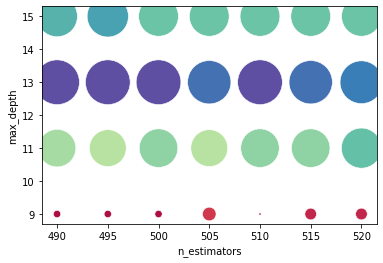

In [34]:
sns.scatterplot(data=results_orig, x='n_estimators', y='max_depth',
    hue='f1', size='f1', sizes=(5, 2000), palette='Spectral', legend=False)
plt.show()

На диаграмме видно, что модели с максимальной _F1_ получаются при максимальной глубине деревьев, близкой к 13. Изучим подробнее окрестности значения `max_depth` = 13.

In [35]:
results_orig_2 = sort_models(data_orig, range(12, 15, 1), range(485, 521, 3))
print(results_orig_2.sort_values('f1', ascending=False).head(10))

    n_estimators  max_depth        f1   roc_auc
19         506.0       13.0  0.579216  0.857959
17         500.0       13.0  0.579216  0.857847
16         497.0       13.0  0.579216  0.857605
15         494.0       13.0  0.579216  0.857575
14         491.0       13.0  0.579216  0.857689
18         503.0       13.0  0.576792  0.857869
13         488.0       13.0  0.576792  0.857612
23         518.0       13.0  0.576792  0.857616
22         515.0       13.0  0.576792  0.857616
20         509.0       13.0  0.576792  0.857951


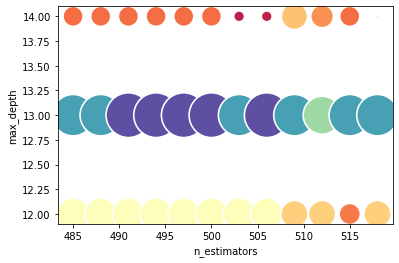

In [36]:
sns.scatterplot(data=results_orig_2, x='n_estimators', y='max_depth',
    hue='f1', size='f1', sizes=(5, 2000), palette='Spectral', legend=False)
plt.show()

Если остановиться на `max_depth` = 13, снова сузить диапазон `n_estimators` и уменьшить шаг циклов до 1, то обнаружится 14 моделей с максимальным (в пределах точности применяемых инструменов) _F1_ = 0,5792163543441228.

In [37]:
results_orig_3 = sort_models(data_orig, range(13, 14, 1), range(487, 512, 1))

In [38]:
f1_max = results_orig_3.f1.max()
max_orig_3 = results_orig_3[results_orig_3.f1 == f1_max]
print('Максимальное значение F1 =', f1_max)
print('Количество потенциально оптимальных моделей:', len(max_orig_3))

Максимальное значение F1 = 0.5792163543441228
Количество потенциально оптимальных моделей: 14


Будем считать оптимальной моделью ту, где требуется меньше всего деревьев случайного леса, а именно 489. Значение _AUC-ROC_ для этой модели составляет 0,857691.

In [39]:
est_min = max_orig_3.n_estimators.min()
print('Оптимальная модель:')
print('Количество деревьев:', est_min)
print('AUC-ROC:', max_orig_3[max_orig_3.n_estimators == est_min].roc_auc.iloc[0])

Оптимальная модель:
Количество деревьев: 489.0
AUC-ROC: 0.8576905094097463


В результате этого подбора модели не достигнуто значение _F1_ = 0,59, необходимое по условию задачи. На следующих этапах оптимизируем процедуру, чтобы достичь его.

#### Улучшение модели

##### Стандартизация

Стандартизируем числовые столбцы с помощью `StandardScaler`.

In [40]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])
data_scaled = get_samples(df_scaled)

In [41]:
# --- ДЛЯ ПРОВЕРКИ ---

scaler_v2 = StandardScaler()

# делим исходный набор данных на 6 кусков:
data_scaled_v2 = get_samples(df)

# ранее объявлен список:
# num_cols = ['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'NumOfProducts', 'Tenure']

# обучаем scaler_v2 на числовых столбцах только из обучающей выборки x_train
scaler_v2.fit(data_scaled_v2['x_train'][num_cols])

# применяем обученный scaler_v2 ко всем трём прогнозирующим выборкам
for key in ['x_train', 'x_valid', 'x_test']:
    data_scaled_v2[key][num_cols] = scaler_v2.transform(data_scaled_v2[key][num_cols])

Продемонстрируем _последний_ этап подбора оптимальной модели. (Напомню, что полный код предыдущих этапов не умещается в Jupyter.)

In [42]:
results_scaled = sort_models(data_scaled, range(13, 14, 1), range(405, 425, 1))

Максимальное значение _F1_ составляет 0,5792163543441228 — то есть _ровно столько же_, сколько при подборе модели без стандартизации, и тоже достигается при максимальной глубине деревьев, равной 13. Однако теперь достаточно 410 деревьев (по сравнению с 498 в случае без стандартизации).

In [43]:
f1_max = results_scaled.f1.max()
max_scaled = results_scaled[results_scaled.f1 == f1_max]
print('Максимальное значение F1 =', f1_max)
print('Количество потенциально оптимальных моделей:', len(max_scaled))

Максимальное значение F1 = 0.5792163543441228
Количество потенциально оптимальных моделей: 6


In [44]:
est_min = max_scaled.n_estimators.min()
print('Оптимальная модель:')
print('Количество деревьев:', est_min)
print('AUC-ROC:', max_scaled[max_scaled.n_estimators == est_min].roc_auc.iloc[0])

Оптимальная модель:
Количество деревьев: 410.0
AUC-ROC: 0.8567330493240964


##### Взвешивание

Баланс классов целевого признака `Exited` составляет 4:1. Сбалансируем классы путём присваивания весов.

На локальном компьютере была подобрана оптимальная модель с 880 деревьями и максимальной глубиной дерева 9.

In [45]:
model_w = RandomForestClassifier(max_depth=9, n_estimators=880,
    random_state=random_state_default, class_weight='balanced')
model_w.fit(data_orig['x_train'], data_orig['y_train_true'])
y_valid_pred_w = model_w.predict(data_orig['x_valid'])

Значение _F1_-меры для оптимальной модели составляет 0,6146, что превышает необходимый минимум (0,59) более чем на 0,02. _AUC_ROC_ равен 0,864: это тоже больше, чем в предыдущих моделях.

In [46]:
f1_w = f1_score(data_orig['y_valid_true'], y_valid_pred_w)
roc_auc_w = roc_auc_score(data_orig['y_valid_true'], model_w.predict_proba(data_orig['x_valid'])[:, 1])
print('F1 = ', f1_w)
print('AUC-ROC =', roc_auc_w)

F1 =  0.6145966709346992
AUC-ROC = 0.8635451729295857


##### Стандартизация и взвешивание

Применим к набору данных одновременно стандартизацию и взвешивание.

На локальном компьютере была подобрана оптимальная модель с 835 деревьями и максимальной глубиной дерева 9.

In [47]:
model_final = RandomForestClassifier(max_depth=9, n_estimators=835,
    random_state=random_state_default, class_weight='balanced')
model_final.fit(data_scaled['x_train'], data_scaled['y_train_true'])
y_valid_pred_final = model_final.predict(data_scaled['x_valid'])

Эффекты обоих методов объединились: максимальное значение _F1_ = 0,616 оказалось выше, чем на всех предыдущих этапах, а деревьев понадобилось на 45 штук меньше, чем в случае взвешивания без стандартизации.

In [48]:
f1_final = f1_score(data_scaled['y_valid_true'], y_valid_pred_final)
roc_auc_final = roc_auc_score(data_scaled['y_valid_true'],
                              model_final.predict_proba(data_scaled['x_valid'])[:, 1])
print('F1 =', f1_final)
print('AUC-ROC =', roc_auc_final)

F1 = 0.6157760814249363
AUC-ROC = 0.8635991930511496


### Тестирование модели

Финальная модель показывает хорошие результаты на тестовой выборке: _F1_ = 0,638, _AUC-ROC_ = 0,880, причём оба этих значения даже выше, чем на валидационной выборке.

In [49]:
y_test_pred = model_final.predict(data_scaled['x_test'])
f1_test = f1_score(data_scaled['y_test_true'], y_test_pred)
roc_auc_test = roc_auc_score(data_scaled['y_test_true'], model_final.predict_proba(data_scaled['x_test'])[:, 1])
print('F1 =', f1_test)
print('AUC-ROC =', roc_auc_test)

F1 = 0.6382428940568476
AUC-ROC = 0.8796015695968786


#### Корреляция Мэтьюса

В модели бинарной классификации мне было бы милее оптимизировать не _F1_-меру, а коэффициент корреляции Мэтьюса (MCC), который, в отличие от _F1_, учитывает также количество истинно отрицательных ответов (_TN_). По этому критерию оптимальным оказывается случайный лес с 828 деревьями и максимальной глубиной дерева 10. Впрочем, _F1_ и _AUC-ROC_ у этой модели тоже близки к максимальным значениям.

In [50]:
model_mcc = RandomForestClassifier(max_depth=10, n_estimators=828,
    random_state=random_state_default, class_weight='balanced')
model_mcc.fit(data_scaled['x_train'], data_scaled['y_train_true'])
y_valid_pred_mcc = model_mcc.predict(data_scaled['x_valid'])

In [51]:
f1_mcc = f1_score(data_scaled['y_valid_true'], y_valid_pred_mcc)
roc_auc_mcc = roc_auc_score(data_scaled['y_valid_true'],
                              model_mcc.predict_proba(data_scaled['x_valid'])[:, 1])
mcc = matthews_corrcoef(data_scaled['y_valid_true'], y_valid_pred_mcc)
print('F1 =', f1_mcc)
print('AUC-ROC =', roc_auc_mcc)
print('MCC =', mcc)

F1 = 0.6145404663923182
AUC-ROC = 0.8629099708105066
MCC = 0.5180445423999255


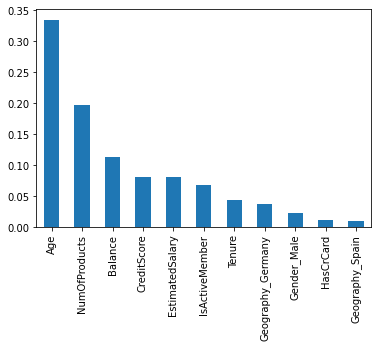

In [52]:
forest_importances = pd.Series(model_final.feature_importances_, index=data_scaled['x_train'].columns)
forest_importances.sort_values(ascending=False).plot.bar()
plt.show()

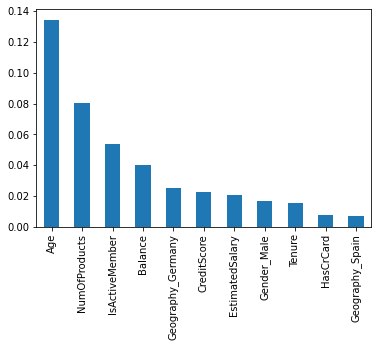

In [53]:
from sklearn.inspection import permutation_importance
results = permutation_importance(
    model_final, data_scaled['x_train'], data_scaled['y_train_true'],
    n_repeats=10, random_state=random_state_default, n_jobs=2
)
forest_importances_perm = pd.Series(results.importances_mean, index=data_scaled['x_train'].columns)
forest_importances_perm.sort_values(ascending=False).plot.bar()
plt.show()